In [5]:
import pandas as pd
import numpy as np
import scipy as sc

from tqdm.notebook import tqdm
from tqdm import tqdm

In [ ]:
import gdown

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [ ]:
url = "https://drive.google.com/uc?id=1-CcS22-UpTJeNcFlA0dVLrEQn8jnI0d-"

output = 'train.csv'
gdown.download(url, output, quiet=True)

# test
url = "https://drive.google.com/uc?id=11iz3xDh0IIoEIBY0dyRSvByY3qfiT3BG"

output = 'test.csv'
gdown.download(url, output, quiet=True)

# user features
url = "https://drive.google.com/uc?id=1zl2jWMdUhc-IMakHlihQhJ5PGGZm9-_O"
output = 'users.csv'
gdown.download(url, output, quiet=True, fuzzy=True)

# item features
url = "https://drive.google.com/uc?id=1chCmpiCKJRjdqNftHc-t2ALl3qbAp2G8"
output = 'items.csv'
gdown.download(url, output, quiet=True)

In [6]:
users = pd.read_csv("users.csv")
items = pd.read_csv("items.csv")
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [7]:
train_df['last_watch_dt'] = pd.to_datetime(train_df['last_watch_dt'])

In [8]:
train_cutoff = train_df['last_watch_dt'].quantile(0.8)
valid_cutoff = train_df['last_watch_dt'].quantile(0.9)

In [9]:
train_stage_1 = train_df[train_df['last_watch_dt'] < train_cutoff].copy()
valid_stage_1 = train_df[(train_df['last_watch_dt'] >= train_cutoff) & (train_df['last_watch_dt'] < valid_cutoff)].copy()
test_df = test_df.copy()

In [10]:
train_users = train_stage_1['user_id'].unique()
valid_users = valid_stage_1['user_id'].unique()
test_users = test_df['user_id'].unique()

all_included = np.intersect1d(np.intersect1d(valid_users, train_users), test_users)

In [ ]:
#n_users = 1000 
#selected_users = np.random.choice(all_included, size=n_users, replace=False)

#train_stage_1 = train_stage_1[train_stage_1['user_id'].isin(selected_users)].copy()
#valid_stage_1 = valid_stage_1[valid_stage_1['user_id'].isin(selected_users)].copy()
#test_df = test_df[test_df['user_id'].isin(selected_users)].copy()

In [11]:
train_stage_1 = train_stage_1[train_stage_1['user_id'].isin(all_included)].copy()
valid_stage_1 = valid_stage_1[valid_stage_1['user_id'].isin(all_included)].copy()
test_df = test_df[test_df['user_id'].isin(all_included)].copy()

In [12]:
print("Train Stage 1 shape:", train_stage_1.shape)
print("Validation Stage 1 shape:", valid_stage_1.shape)
print("Test shape:", test_df.shape)

Train Stage 1 shape: (700644, 6)
Validation Stage 1 shape: (167719, 6)
Test shape: (160780, 6)


Эврестическая модель

In [9]:
class HeuristicModel:
    def __init__(self, train_data, user_data):
        self.recommendations = train_data.merge(user_data, on='user_id')
        
        # Подсчет популярности айтемов
        item_popularity = self.recommendations.groupby("item_id")["user_id"].count()
        item_rank = item_popularity.rank(method='min', ascending=False)
        self.item_popularity_df = item_rank.reset_index().rename(columns={"user_id": "popularity_rank"})
        
        # Средний процент просмотра айтемов
        item_mean_watch = self.recommendations.groupby("item_id")["watched_pct"].mean().reset_index()
        
        # Объединение данных и расчет релевантности
        self.item_recommendations = item_mean_watch.merge(self.item_popularity_df, on='item_id')
        self.item_recommendations["relevance_score"] = (
            self.item_recommendations["watched_pct"] / np.log1p(self.item_recommendations["popularity_rank"])
        )
        self.item_recommendations = self.item_recommendations.sort_values("relevance_score", ascending=False)
    
    def get_score(self, user_id, item_id):
        try:
            score = self.item_recommendations.loc[
                self.item_recommendations["item_id"] == item_id, "relevance_score"
            ].values[0]
        except IndexError:
            score = 0  # если айтема нет
        return score

    def get_top_k(self, k, user_id=None):
        if user_id is not None:
            user_items = self.recommendations[self.recommendations["user_id"] == user_id]["item_id"].values
        else:
            user_items = []
        
        top_k_items = self.item_recommendations[
            ~self.item_recommendations["item_id"].isin(user_items)
        ]["item_id"].head(k).values
        return top_k_items


In [10]:
train_stage_1

,user_id,item_id,last_watch_dt,total_dur,watched_pct,target
2,889459,11460,2021-03-13,60,0.0,0
15,382278,11494,2021-03-13,4908,100.0,1
17,902619,12544,2021-03-13,2203,34.0,0
19,671628,12637,2021-03-13,5573,100.0,1
20,1017494,3220,2021-03-13,2531,46.0,0
...,...,...,...,...,...,...
3891720,278240,14177,2021-07-25,9687,100.0,1
3891727,883492,16043,2021-07-25,695,16.0,0
3891733,612427,6577,2021-07-25,4850,92.0,1
3891736,942500,9728,2021-07-25,10016,100.0,1


In [11]:
heuristic_model = HeuristicModel(train_stage_1, users)

print("Score:", heuristic_model.get_score(1017494, 13865))
print("Top-5:", heuristic_model.get_top_k(5, user_id=1017494))

Score: 110.33220214657305
Top-5: [13865  9728  3734   142  8636]


Матричная факторизация

In [12]:
class ALSMatrixFactorization:
    def __init__(self, n_factors=20, n_iterations=10, reg=0.1):
        self.n_factors = n_factors
        self.n_iterations = n_iterations 
        self.reg = reg 

    def fit(self, train_data):
        # Создаем матрицу взаимодействий
        self.user_item_matrix = train_data.pivot(index='user_id', columns='item_id', values='watched_pct').fillna(0)
        self.users = self.user_item_matrix.index.values
        self.items = self.user_item_matrix.columns.values

        self.user_factors = np.random.normal(scale=1.0 / self.n_factors, size=(len(self.users), self.n_factors))
        self.item_factors = np.random.normal(scale=1.0 / self.n_factors, size=(len(self.items), self.n_factors))

        # ALS
        for iteration in range(self.n_iterations):
            for i, item in enumerate(self.items):
                user_ratings = self.user_item_matrix.iloc[:, i].values
                non_zero_indices = user_ratings > 0
                if np.any(non_zero_indices):
                    A = self.user_factors[non_zero_indices].T @ self.user_factors[non_zero_indices] + self.reg * np.eye(self.n_factors)
                    b = self.user_factors[non_zero_indices].T @ user_ratings[non_zero_indices]
                    self.item_factors[i] = np.linalg.solve(A, b)

            for u, user in enumerate(self.users):
                item_ratings = self.user_item_matrix.iloc[u, :].values
                non_zero_indices = item_ratings > 0
                if np.any(non_zero_indices):
                    A = self.item_factors[non_zero_indices].T @ self.item_factors[non_zero_indices] + self.reg * np.eye(self.n_factors)
                    b = self.item_factors[non_zero_indices].T @ item_ratings[non_zero_indices]
                    self.user_factors[u] = np.linalg.solve(A, b)

    def get_score(self, user_id, item_id):
        # Получение скора для пары user-item
        if user_id in self.users and item_id in self.items:
            user_idx = np.where(self.users == user_id)[0][0]
            item_idx = np.where(self.items == item_id)[0][0]
            return np.dot(self.user_factors[user_idx], self.item_factors[item_idx])
        return 0

    def get_top_k(self, k, user_id):
        if user_id not in self.users:
            return []  # Если пользователь отсутствует
        user_idx = np.where(self.users == user_id)[0][0]
        scores = np.dot(self.item_factors, self.user_factors[user_idx])
        top_k_items = np.argsort(scores)[::-1][:k]
        return self.items[top_k_items]

In [13]:
als_model = ALSMatrixFactorization(n_factors=20, n_iterations=10, reg=0.1)
als_model.fit(train_stage_1)

print("Score:", als_model.get_score(1017494, 13865))
print("Top-5:", als_model.get_top_k(5, user_id=1017494))

Score: 83.30974350791567
Top-5: [ 6853  2667  2491  9123 12784]


Нейросетевая модель

In [14]:
class RecSysDataset(Dataset):
    def __init__(self, df):
        self.users = torch.tensor(df['user_id'].values, dtype=torch.long)
        self.items = torch.tensor(df['item_id'].values, dtype=torch.long)
        self.ratings = torch.tensor(df['watched_pct'].values, dtype=torch.float32)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.ratings[idx]

train_stage_1_copy = train_stage_1.copy()

train_dataset = RecSysDataset(train_stage_1_copy)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


class NeuralRecSys(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=32):
        super(NeuralRecSys, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)
        self.fc = nn.Sequential(
            nn.Linear(embedding_dim * 2, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, user, item):
        user_emb = self.user_embedding(user)
        item_emb = self.item_embedding(item)
        x = torch.cat([user_emb, item_emb], dim=-1)
        return self.fc(x).squeeze()
    
class NeuralNetworkModel:
    def __init__(self, model, device):
        self.model = model
        self.device = device

    def get_score(self, user_id, item_id):
        self.model.eval()
        with torch.no_grad():
            user = torch.tensor([user_id], dtype=torch.long).to(self.device)
            item = torch.tensor([item_id], dtype=torch.long).to(self.device)
            return self.model(user, item).item()

    def get_top_k(self, k, user_id):
        self.model.eval()
        all_items = train_stage_1['item_id'].unique()
        scores = []
        with torch.no_grad():
            user = torch.tensor([user_id], dtype=torch.long).to(self.device)
            for item in all_items:
                item_tensor = torch.tensor([item], dtype=torch.long).to(self.device)
                score = self.model(user, item_tensor).item()
                scores.append((item, score))
        scores = sorted(scores, key=lambda x: x[1], reverse=True)
        return [item for item, score in scores[:k]]

In [15]:
# Определение количества пользователей и айтемов
num_users = train_stage_1['user_id'].max() + 1
num_items = train_stage_1['item_id'].max() + 1

print("Кол-во пользователей:", num_users)
print("Кол-во айтемов:", num_items)

Кол-во пользователей: 1097545
Кол-во айтемов: 16517


In [16]:
model = NeuralRecSys(num_users, num_items)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(5):
    model.train()
    epoch_loss = 0
    for users, items, ratings in train_loader:
        users = users.to(torch.long).to(device)
        items = items.to(torch.long).to(device)
        ratings = ratings.to(torch.float32).to(device)

        optimizer.zero_grad()
        predictions = model(users, items)
        loss = criterion(predictions, ratings)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {epoch_loss / len(train_loader)}")

Epoch 1, Loss: 1599.6334238160384
Epoch 2, Loss: 1384.3551688147236
Epoch 3, Loss: 1308.2378870748366
Epoch 4, Loss: 1265.911163307778
Epoch 5, Loss: 1233.9060062719254


In [17]:
nn_model = NeuralNetworkModel(model, device)

print("Score:", nn_model.get_score(1017494, 13865))
print("Top-5:", nn_model.get_top_k(5, user_id=1017494))

Score: 96.24147033691406
Top-5: [np.int64(11545), np.int64(13580), np.int64(9522), np.int64(10827), np.int64(10191)]



### 2 Этап. Генерация и сборка признаков. (max 2 балла)
Необходимо собрать минимум 10 осмысленных (`np.radndom.rand()` не подойдет) признаков, при этом:
1. 2 должны относиться только к сущности "пользователь" (например средний % просмотра фильмов у этой возрастной категории)
2. 2 должны относиться только к сущности "айтем" (например средний средний % просмотра данного фильма)
3. 6 признаков, которые показывают связь пользователя и айтема (например средний % просмотра фильмов с данным актером (айтем) у пользователей с таким же полом (пользователь)). 

### ВАЖНО!  

1. **В датасете есть колонка `watched_prct`. Ее можно использовать для генерации признаков (например сколько пользователь в среднем смотрит фильмы), но нельзя подавать в модель, как отдельную фичу, потому что она напрямую связана с target.**
2. **Все признаки должны быть собраны без дата лика, то есть если пользователь посмотрел фильм 10 августа, то признаки мы можем считать только на данных до 9 августа включительно.**


### Разбалловка
Обучение ранкера будет проходить на `valid_stage_1`, как  раз на которой мы валидировали модели, а тестировать на `test`. Поэтому есть 2 варианта сборки признаков, **реализовать нужно только 1 из них:**
1. Для обучения собираем признаки на первый день `valid_stage_1`, а для теста на первый день `test`. Например, если `valid_stage_1` начинается 5 сентября, то все признаки мы можем собирать только по 4 сентября включительно. **(1 балл)**
2. Признаки будем собирать честно на каждый день, то есть на 5 сентября собираем с начала до 4, на 6 сентября с начала до 5 и т.д. **(2 балла)**

In [21]:
print(type(train_stage_1))
print(type(valid_stage_1))
print(type(test_df))
print(type(users))
print(type(items))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [13]:
users = pd.read_csv("users.csv")
items = pd.read_csv("items.csv")

In [14]:
# Объединение данных
feature_creation_df = pd.concat([train_stage_1, valid_stage_1, test_df]).merge(users, on='user_id').merge(items, on='item_id')
feature_creation_df['last_watch_dt'] = pd.to_datetime(feature_creation_df['last_watch_dt'])

# Список для хранения результатов
feature_dataframe_list = []

# Генерация признаков
for date in tqdm(feature_creation_df['last_watch_dt'].dropna().unique()):
    # Данные до текущей даты
    historical_data = feature_creation_df[feature_creation_df['last_watch_dt'] < date].copy()
    current_data = feature_creation_df[feature_creation_df['last_watch_dt'] == date].copy()
    current_data['last_watch_dt'] = date

    # Признаки для пользователей
    user_feature_1 = historical_data.groupby(['user_id'])['watched_pct'].mean().reset_index().rename(columns={'watched_pct': 'user_feature_1'})
    user_feature_2 = historical_data.groupby(['user_id'])['watched_pct'].count().reset_index().rename(columns={'watched_pct': 'user_feature_2'})

    # Признаки для айтемов
    item_feature_1 = historical_data.groupby(['item_id'])['watched_pct'].mean().reset_index().rename(columns={'watched_pct': 'item_feature_1'})
    item_feature_2 = historical_data.groupby(['item_id'])['watched_pct'].count().reset_index().rename(columns={'watched_pct': 'item_feature_2'})

    # Признаки для связи пользователь-айтем
    interaction_feature_1 = historical_data.groupby(['user_id', 'item_id'])['watched_pct'].mean().reset_index().rename(columns={'watched_pct': 'interaction_feature_1'})
    interaction_feature_2 = historical_data.groupby(['user_id', 'genres'])['watched_pct'].mean().reset_index().rename(columns={'watched_pct': 'interaction_feature_2'})
    interaction_feature_3 = historical_data.groupby(['user_id', 'countries'])['watched_pct'].mean().reset_index().rename(columns={'watched_pct': 'interaction_feature_3'})
    interaction_feature_4 = historical_data.groupby(['user_id', 'release_year'])['watched_pct'].mean().reset_index().rename(columns={'watched_pct': 'interaction_feature_4'})
    interaction_feature_5 = historical_data.groupby(['user_id', 'directors'])['watched_pct'].mean().reset_index().rename(columns={'watched_pct': 'interaction_feature_5'})
    interaction_feature_6 = historical_data.groupby(['user_id', 'actors'])['watched_pct'].mean().reset_index().rename(columns={'watched_pct': 'interaction_feature_6'})

    # Объединение признаков с текущими данными
    current_data = current_data.merge(user_feature_1, on='user_id', how='left')
    current_data = current_data.merge(user_feature_2, on='user_id', how='left')
    current_data = current_data.merge(item_feature_1, on='item_id', how='left')
    current_data = current_data.merge(item_feature_2, on='item_id', how='left')
    current_data = current_data.merge(interaction_feature_1, on=['user_id', 'item_id'], how='left')
    current_data = current_data.merge(interaction_feature_2, on=['user_id', 'genres'], how='left')
    current_data = current_data.merge(interaction_feature_3, on=['user_id', 'countries'], how='left')
    current_data = current_data.merge(interaction_feature_4, on=['user_id', 'release_year'], how='left')
    current_data = current_data.merge(interaction_feature_5, on=['user_id', 'directors'], how='left')
    current_data = current_data.merge(interaction_feature_6, on=['user_id', 'actors'], how='left')

    # Сохранение результатов
    feature_dataframe_list.append(current_data[['user_id', 'item_id', 'last_watch_dt'] + 
                                               [f"user_feature_{i+1}" for i in range(2)] +
                                               [f"item_feature_{i+1}" for i in range(2)] +
                                               [f"interaction_feature_{i+1}" for i in range(6)]])

# Объединение всех данных
feature_df = pd.concat(feature_dataframe_list)

# Приведение дат к формату datetime
test_df['last_watch_dt'] = pd.to_datetime(test_df['last_watch_dt'])
train_stage_1['last_watch_dt'] = pd.to_datetime(train_stage_1['last_watch_dt'])
valid_stage_1['last_watch_dt'] = pd.to_datetime(valid_stage_1['last_watch_dt'])

# Объединение признаков с train, valid и test
test_df_with_features = test_df.reset_index(drop=True).merge(feature_df, on=['user_id', 'item_id', 'last_watch_dt'], how='left')
train_df_with_features = train_stage_1.reset_index(drop=True).merge(feature_df, on=['user_id', 'item_id', 'last_watch_dt'], how='left')
valid_df_with_features = valid_stage_1.reset_index(drop=True).merge(feature_df, on=['user_id', 'item_id', 'last_watch_dt'], how='left')

# Заполнение пропущенных значений
test_df_with_features.fillna(0, inplace=True)
train_df_with_features.fillna(0, inplace=True)
valid_df_with_features.fillna(0, inplace=True)

100%|██████████| 154/154 [01:37<00:00,  1.58it/s]


In [15]:
test_df_with_features

,user_id,item_id,last_watch_dt,total_dur,watched_pct,target,user_feature_1,user_feature_2,item_feature_1,item_feature_2,interaction_feature_1,interaction_feature_2,interaction_feature_3,interaction_feature_4,interaction_feature_5,interaction_feature_6
0,1079425,4141,2021-08-13,774,10.0,0,37.700000,10.0,62.575000,440.0,0.0,0.0,20.000000,2.0,0.0,0.0
1,104928,15221,2021-08-13,1560,30.0,0,58.800000,10.0,68.897436,234.0,0.0,50.0,0.000000,0.0,0.0,0.0
2,661351,12228,2021-08-13,5184,50.0,0,37.944444,54.0,58.153971,617.0,0.0,0.0,28.294118,0.0,75.0,0.0
3,975519,10440,2021-08-13,17483,90.0,1,23.615385,13.0,58.603893,11661.0,0.0,0.0,16.000000,21.0,0.0,0.0
4,523880,3940,2021-08-13,21916,100.0,1,75.294118,17.0,73.371542,506.0,0.0,100.0,74.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160775,563193,6965,2021-08-22,1350,18.0,0,50.352941,51.0,50.771784,241.0,0.0,0.0,14.333333,99.0,0.0,0.0
160776,820997,175,2021-08-22,1658,32.0,0,14.000000,5.0,45.701209,579.0,0.0,10.0,39.000000,10.0,0.0,0.0
160777,337137,6227,2021-08-22,116,0.0,0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
160778,1035030,10201,2021-08-22,1154,19.0,0,64.000000,7.0,53.419872,312.0,0.0,0.0,11.000000,0.0,0.0,0.0



### 3 Этап. Обучение финального ранкера (max 2 балла)
Собрав все признаки из этапа 2, добавив скоры моделей из этапа 1 для каждой пары пользователь-айтем (где это возможно), пришло время обучать ранкер. В качестве ранкера можно использовать либо [xgboost](https://xgboost.readthedocs.io/en/stable/) или [catboost](https://catboost.ai/). Обучать можно как `Classfier`, так и `Ranker`, выбираем то, что лучше сработает. Обучение ранкера будет проходить на `valid_stage_1`, как  раз на которой мы валидировали модели, а тестировать на `test`, которую мы до сих пор не трогали.  Заметьте, что у нас в тесте есть холодные пользователи – те, кого не было в train и активные – те, кто был в train. Возможно их стоит обработать по отдельности (а может и нет).  
(1 балл)

После получения лучшей модели надо посмотреть на важность признаков и [shap values](https://shap.readthedocs.io/en/latest/index.html), чтобы:
1. Интерпритировать признаки, которые вы собрали, насколько они полезные
2. Проверить наличие ликов – если важность фичи в 100 раз больше, чем у всех остальных, то явно что-то не то  

(1 балл)






In [16]:
train_data = train_df_with_features.copy()
valid_data = valid_df_with_features.copy()
test_data = test_df_with_features.copy()

train_data.fillna(0, inplace=True)
valid_data.fillna(0, inplace=True)
test_data.fillna(0, inplace=True)

X_train = train_data.drop(columns=['target', 'user_id', 'item_id', 'last_watch_dt'])
y_train = train_data['target']

X_valid = valid_data.drop(columns=['target', 'user_id', 'item_id', 'last_watch_dt'])
y_valid = valid_data['target']

X_test = test_data.drop(columns=['target', 'user_id', 'item_id', 'last_watch_dt'])

In [20]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score

model = CatBoostClassifier(iterations=500, learning_rate=0.1, depth=6, eval_metric='AUC', verbose=100)

model.fit(X_train, y_train, eval_set=(X_valid, y_valid), use_best_model=True)

y_valid_pred = model.predict_proba(X_valid)[:, 1]
print("Validation AUC:", roc_auc_score(y_valid, y_valid_pred))

0:	test: 1.0000000	best: 1.0000000 (0)	total: 127ms	remaining: 1m 3s
100:	test: 1.0000000	best: 1.0000000 (0)	total: 3.25s	remaining: 12.9s
200:	test: 1.0000000	best: 1.0000000 (0)	total: 6.49s	remaining: 9.66s
300:	test: 1.0000000	best: 1.0000000 (0)	total: 9.86s	remaining: 6.52s
400:	test: 1.0000000	best: 1.0000000 (0)	total: 13.3s	remaining: 3.29s
499:	test: 1.0000000	best: 1.0000000 (0)	total: 16.6s	remaining: 0us

bestTest = 1
bestIteration = 0

Shrink model to first 1 iterations.
Validation AUC: 1.0


In [21]:
feature_importances = model.get_feature_importance(prettified=True)
print(feature_importances)

               Feature Id  Importances
0             watched_pct    99.556381
1               total_dur     0.166642
2          item_feature_1     0.149574
3   interaction_feature_3     0.113172
4   interaction_feature_6     0.014231
5          user_feature_1     0.000000
6          user_feature_2     0.000000
7          item_feature_2     0.000000
8   interaction_feature_1     0.000000
9   interaction_feature_2     0.000000
10  interaction_feature_4     0.000000
11  interaction_feature_5     0.000000


c:\Users\seant3llis\Documents\projects\envs\main312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


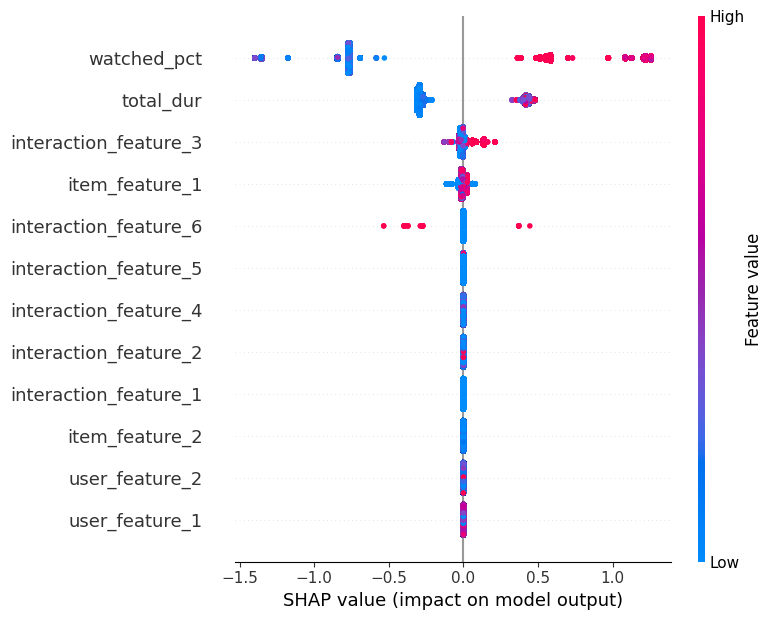

In [22]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_valid)

shap.summary_plot(shap_values, X_valid)

In [23]:
y_test_pred = model.predict_proba(X_test)[:, 1]

cold_users = test_data[~test_data['user_id'].isin(train_data['user_id'])]
active_users = test_data[test_data['user_id'].isin(train_data['user_id'])]

y_cold_pred = model.predict_proba(cold_users.drop(columns=['target', 'user_id', 'item_id', 'last_watch_dt']))[:, 1]
y_active_pred = model.predict_proba(active_users.drop(columns=['target', 'user_id', 'item_id', 'last_watch_dt']))[:, 1]

print("Preds")

Preds


No objects info loaded
